## Figure 6
Results from a parcel simulation with Na = 200 cm-3, ra = 50 nm, Forg = 0.5, and w = 0.5 m/s.
Difference in CDNC profiles and supersaturation profiles between the different surface-partitioning models and constant surface tension.
Solid lines show best fit parameter values, while shading indicates the variability from changing the parameter values within 1std.

Comparing the structural vs. parametric uncertainty. Are shadings wider than difference between curves?

In [2]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install "open_atmos_jupyter_utils"
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [3]:
import numpy as np
from joblib import Parallel, delayed
import pickle as pkl

from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.initialisation.spectra import Sum

from PySDM_examples.Singer_Ward import Settings, ParcelSimulation
from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark
from PySDM_examples.Singer_Ward.kappa_mcmc import param_transform
from PySDM_examples.Singer_Ward.constants_def import SINGER_CONSTS, plot_colors, plot_lines, plot_names

In [5]:
FORMULAE = Formulae(constants=SINGER_CONSTS)
WATER_MOLAR_VOLUME = FORMULAE.constants.water_molar_volume

models = ('CompressedFilmOvadnevaite', 'SzyszkowskiLangmuir', 'CompressedFilmRuehl')
aerosol = AerosolBetaCaryophylleneDark(water_molar_volume=WATER_MOLAR_VOLUME, Forg=0.5, N_a=200, r_a=50)
aerosolname = aerosol.__class__.__name__.split("Aerosol")[1]

model = "CompressedFilmOvadnevaite"
N = 1000
Ncut = 500
modelname = model.split("CompressedFilm")[-1]
outputfile = f"mcmc_output/{aerosolname}_{modelname}_chain{N}.csv"
param_chain = np.loadtxt(outputfile, delimiter=",").T
data_OV = param_transform(param_chain, model).T[Ncut:, :]

model = "SzyszkowskiLangmuir"
N = 1500
modelname = model.split("CompressedFilm")[-1]
outputfile = f"mcmc_output/{aerosolname}_{modelname}_chain{N}.csv"
param_chain = np.loadtxt(outputfile, delimiter=",").T
data_SL = param_transform(param_chain, model).T[Ncut:, :]

model = "CompressedFilmRuehl"
N = 5000
modelname = model.split("CompressedFilm")[-1]
outputfile = f"mcmc_output/{aerosolname}_{modelname}_chain{N}.csv"
param_chain = np.loadtxt(outputfile, delimiter=",").T
data_RU = param_transform(param_chain, model).T[Ncut:, :]


def sample_stc(model):
    if model == "CompressedFilmOvadnevaite":
        randn = np.random.randint(0, len(data_OV))
        stc = {
            'sgm_org': data_OV[randn, 0] * si.mN / si.m,
            'delta_min': data_OV[randn, 1] * si.nm,
        }
    if model == "SzyszkowskiLangmuir":
        randn = np.random.randint(0, len(data_SL))
        stc = {
            'RUEHL_nu_org': aerosol.modes[0]['nu_org'],
            'RUEHL_A0': data_SL[randn, 0] * si.m**2,
            'RUEHL_C0': data_SL[randn, 1],
            'RUEHL_sgm_min': data_SL[randn, 2] * si.mN / si.m,
        }
    if model == "CompressedFilmRuehl":
        randn = np.random.randint(0, len(data_RU))
        stc = {
            'RUEHL_nu_org': aerosol.modes[0]['nu_org'],
            'RUEHL_A0': data_RU[randn, 0] * si.m**2,
            'RUEHL_C0': data_RU[randn, 1],
            'RUEHL_sgm_min': data_RU[randn, 2] * si.mN / si.m,
            'RUEHL_m_sigma': data_RU[randn, 3] * si.J / si.m**2,
        } 
    return stc

def median_stc(model):
    if model == "CompressedFilmOvadnevaite":
        stc = {
            'sgm_org': np.median(data_OV[:, 0]) * si.mN / si.m,
            'delta_min': np.median(data_OV[:, 1]) * si.nm,
        }
    if model == "SzyszkowskiLangmuir":
        stc = {
            'RUEHL_nu_org': aerosol.modes[0]['nu_org'],
            'RUEHL_A0': np.median(data_SL[:, 0]) * si.m**2,
            'RUEHL_C0': np.median(data_SL[:, 1]),
            'RUEHL_sgm_min': np.median(data_SL[:, 2]) * si.mN / si.m,
        }
    if model == "CompressedFilmRuehl":
        stc = {
            'RUEHL_nu_org': aerosol.modes[0]['nu_org'],
            'RUEHL_A0': np.median(data_RU[:, 0]) * si.m**2,
            'RUEHL_C0': np.median(data_RU[:, 1]),
            'RUEHL_sgm_min': np.median(data_RU[:, 2]) * si.mN / si.m,
            'RUEHL_m_sigma': np.median(data_RU[:, 3]) * si.J / si.m**2,
        } 
    return stc


def genkey(model, sample):
    return f"{model}-{sample}"

def compute(key, settings):
        simulation = ParcelSimulation(settings)
        output = simulation.run()
        model = key.split("-")[0]
        output['stc'] = settings.stc,
        output['color'] = plot_colors[model]
        output['linestyle'] = plot_lines[model]
        output['Na_tot'] = Sum(
            tuple(settings.aerosol.modes[i]['spectrum']
                    for i in range(len(settings.aerosol.modes)))).norm_factor
        return key, output

In [6]:
compute_best_fit = False

if compute_best_fit:
    output_median = dict(Parallel(verbose=10, n_jobs=-1)(
        delayed(compute)(genkey(model, 0), Settings(
            dz = 1 * si.m, 
            n_sd_per_mode = 100, 
            model = model,
            aerosol = aerosol,
            w = 0.5 * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity,
            stc = median_stc(model),
        ))
        for model in models
    ))
    with open('data_fig6_median.pkl','wb') as file:
        pkl.dump(output_median, file)

    _, output_const = compute("Constant-0", Settings(
            dz = 1 * si.m, 
            n_sd_per_mode = 100, 
            model = "Constant",
            aerosol = aerosol,
            w = 0.5 * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity,
        ))
    with open('data_fig6_const.pkl','wb') as file:
        pkl.dump(output_const, file)
else:
    with open('data_fig6_median.pkl','rb') as file:
        output_median = pkl.load(file)
    with open('data_fig6_const.pkl','rb') as file:
        output_const = pkl.load(file)

In [7]:
save = False
restore_saved_data = True
samples = range(10)

if restore_saved_data:
    with open('data_fig6.pkl','rb') as file:
        output = pkl.load(file)
else:
    print(f'tasks scheduled: {len(models) * len(samples)}')
    output = dict(Parallel(verbose=10, n_jobs=-1)(
        delayed(compute)(genkey(model, sample), Settings(
            dz = 1 * si.m, 
            n_sd_per_mode = 100, 
            model = model,
            aerosol = aerosol,
            w = 0.5 * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity,
            stc = sample_stc(model),
        ))
        for model in models
        for sample in samples
    ))
    if save:
        with open('data_fig6.pkl','wb') as file:
            pkl.dump(output, file)

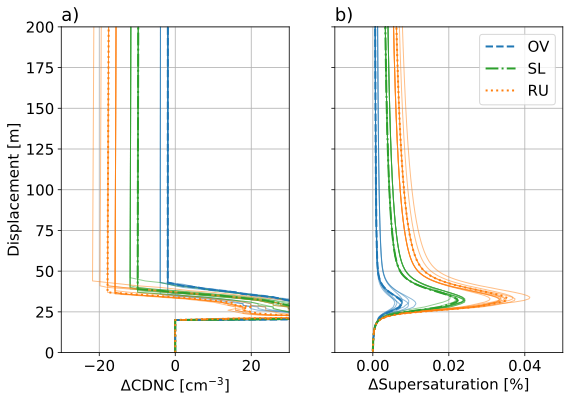

HTML(value="<a href='./fig6.pdf' target='_blank'>./fig6.pdf</a><br>")

In [12]:
fig, axes = pyplot.subplots(1, 2, figsize=(9,6), sharey=True)
pyplot.rcParams.update({"font.size":15})

for i,var in enumerate(("CDNC", "S_max")):
    ax = axes[i]
    for key, output_k in output.items():
        model = key.split("-")[0]
        ax.plot(np.asarray(output_k[var]) - np.asarray(output_const[var]),
                output_k['z'],
                color=output_k['color'],
                linestyle="-",
                lw=1, alpha=0.5,
            )
    for key, output_k in output_median.items():
        model = key.split("-")[0]
        ax.plot(np.asarray(output_k[var]) - np.asarray(output_const[var]),
                output_k['z'],
                label=plot_names[model], 
                color=output_k['color'],
                linestyle=output_k['linestyle'],
                lw=2,
            )
            
    ax.set_ylim(0, 200)
    ax.set_ylabel('Displacement [m]' if i==0 else '')
    ax.set_xlim({0: (-30,30), 1:(-0.01,0.05)}[i])
    ax.grid()
    ax.set_xlabel({0:'$\Delta$CDNC [cm$^{-3}$]', 1:"$\Delta$Supersaturation [%]"}[i])
    ax.set_title({0:"a)", 1:"b)"}[i], loc="left")

ax.legend()

show_plot("fig6.pdf")